<a href="https://colab.research.google.com/github/realhsujoseo/hello-world/blob/main/Final_Project_Sentiment_Analysis_YT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import plotly.figure_factory as ff

# nltk
import pprint
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#intall langdect to detect the language of comments
!pip install langdetect

In [ ]:
from langdetect import detect 

In [ ]:
#use the function to detect the language of the comment
def det(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

In [ ]:
#install emot to covert emoji-only comments into text
!pip install emot

In [ ]:
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

In [ ]:
#Open the Emoji dictionay
with open('/content/drive/MyDrive/For_Final/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

In [ ]:
#use the function to detect if emojis in the dictionary appear in the comments
def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

In [ ]:
#install flair to classfy the comments
!pip install flair

In [ ]:
import flair
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')

2022-01-26 13:36:19,375 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
# Importing the dataset (5 in total))
DATASET_ENCODING = "UTF-8"
Despacito_dataset = pd.read_csv('/content/drive/MyDrive/For_Final/Despacito.csv',
                      encoding=DATASET_ENCODING,index_col= 0)
Shape_of_You_dataset = pd.read_csv('/content/drive/MyDrive/For_Final/Shape_of_You.csv',
                      encoding=DATASET_ENCODING, index_col= 0)
See_You_Again_dataset = pd.read_csv('/content/drive/MyDrive/For_Final/See_You_Again.csv',
                      encoding=DATASET_ENCODING, index_col= 0)
Uptown_Funk_dataset = pd.read_csv('/content/drive/MyDrive/For_Final/Uptown_Funk.csv',
                      encoding=DATASET_ENCODING, index_col= 0)
Gangnam_Style_dataset = pd.read_csv('/content/drive/MyDrive/For_Final/GANGNAM_STYLE.csv',
                      encoding=DATASET_ENCODING, index_col= 0)

In [ ]:
Despacito_dataset

,comment
0,SKIP NAVIGATION\nSIGN IN\n1:04:01\nLuis Fonsi ...
1,“Despacito” disponible ya en todas las platafo...
2,2017 everyone came here to listen masterpiece\...
3,This song never gets old. No matter how much I...
4,Never gets old ❤️
...,...
3579,Where’s 7 billion people on earth??\n\n\nLet’s...
3580,2017: people come here for song\n2020: people ...
3581,Los latinos viendo que los comentarios son en ...
3582,The first viewer must feel like the king of th...


In [ ]:
#add the language column 
Despacito_dataset['Lang'] = Despacito_dataset['comment'].apply(det)
Despacito_dataset

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\n1:04:01\nLuis Fonsi ...,en
1,“Despacito” disponible ya en todas las platafo...,es
2,2017 everyone came here to listen masterpiece\...,en
3,This song never gets old. No matter how much I...,en
4,Never gets old ❤️,nl
...,...,...
3579,Where’s 7 billion people on earth??\n\n\nLet’s...,en
3580,2017: people come here for song\n2020: people ...,en
3581,Los latinos viendo que los comentarios son en ...,es
3582,The first viewer must feel like the king of th...,en


In [ ]:
#check the number of the languages 
top = Counter([item for item in Despacito_dataset['Lang']])
language = pd.DataFrame(top.most_common())
language.columns = ['Lang','count']
language.style.background_gradient(cmap='Greens')

,Lang,count
0,en,1777
1,es,828
2,pt,407
3,Other,80
4,ru,50
5,de,49
6,da,46
7,nl,45
8,it,33
9,ro,27


In [ ]:
fig = px.bar(language, x="count", y="Lang", title='Comments of Languages',orientation='h', 
             width=1000, height=1000,color='Lang')
fig.show()

In [ ]:
#select English comments and comments that were labelled as "Others"
#"Others" may be emoji-only text or null value #drop null value 
Despacito = Despacito_dataset.loc[(Despacito_dataset["Lang"] == "en") | (Despacito_dataset["Lang"] == "Other")].dropna()

In [ ]:
Despacito

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\n1:04:01\nLuis Fonsi ...,en
2,2017 everyone came here to listen masterpiece\...,en
3,This song never gets old. No matter how much I...,en
7,Are you enjoying this world-famous gem of Fons...,en
8,The first viewer must feel like the king of th...,en
...,...,...
3578,The crazy thing is that \n\nmost people that l...,en
3579,Where’s 7 billion people on earth??\n\n\nLet’s...,en
3580,2017: people come here for song\n2020: people ...,en
3582,The first viewer must feel like the king of th...,en


In [ ]:
Despacito_comment = list(Despacito['comment'])

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for comments in textdata:
        comments = comments.lower()
        
        # Replace all URls with 'URL'
        comments = re.sub(urlPattern,' URL',comments)
        # Replace all emojis.
        for emoji in emojis.keys():
            comments = comments.replace(emoji, "EMOJI" + emojis[emoji]) 
        #Replace all emojis which are also in the Emoji Dictionary
        for emot in Emoji_Dict:
            comments = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), comments)
        # Replace @USERNAME to 'USER'.
        comments = re.sub(userPattern,' USER', comments)        
        # Replace all non alphabets.
        comments = re.sub(alphaPattern, " ", comments)
        # Replace 3 or more consecutive letters by 2 letter.
        comments = re.sub(sequencePattern, seqReplacePattern, comments)

        commentswords = ''
        for word in comments.split():
            # Checking if the word is a stopword.
            if word not in stopwordlist:
              if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                commentswords += (word+' ')
            
        processedText.append(commentswords)
        
    return processedText

In [ ]:
import time
t = time.time()
processedtext = preprocess(Despacito_comment)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 259 seconds


In [ ]:
Despacito.loc[:,"comment"] = processedtext 

In [ ]:
Despacito

,comment,Lang
0,skip navigation sign 04 01 luis fonsi sus mejo...,en
2,2017 everyone came listen masterpiece but 2021...,en
3,song never get old no matter much listen never...,en
7,enjoying world famous gem fonsi 2022 legend ye...,en
8,first viewer must feel like king world,en
...,...,...
3578,crazy thing people listen dont even understand...,en
3579,billion people earth let check despacito youtube,en
3580,2017 people come song 2020 people come check v...,en
3582,first viewer must feel like king world,en


In [ ]:
sentiment = []
confidence = []
for sentence in Despacito['comment']:
  if sentence.strip() == "":
    sentiment.append("")
    confidence.append("")
  else:
    sample = flair.data.Sentence(sentence)
    classifier.predict(sample)
    sentiment.append(sample.labels[0].value)
    confidence.append(sample.labels[0].score)

In [ ]:
Despacito['sentiment'] = sentiment
Despacito['confidence'] = confidence

In [ ]:
Despacito

,comment,Lang,sentiment,confidence
0,skip navigation sign 04 01 luis fonsi sus mejo...,en,NEGATIVE,0.973973
2,2017 everyone came listen masterpiece but 2021...,en,POSITIVE,0.858996
3,song never get old no matter much listen never...,en,POSITIVE,0.994348
7,enjoying world famous gem fonsi 2022 legend ye...,en,POSITIVE,0.998311
8,first viewer must feel like king world,en,POSITIVE,0.993193
...,...,...,...,...
3578,crazy thing people listen dont even understand...,en,NEGATIVE,0.998406
3579,billion people earth let check despacito youtube,en,NEGATIVE,0.763995
3580,2017 people come song 2020 people come check v...,en,POSITIVE,0.980396
3582,first viewer must feel like king world,en,POSITIVE,0.993193


In [ ]:
Despacito.groupby('sentiment').count()['comment'].reset_index().sort_values(by='comment')

,sentiment,comment
0,,1
1,NEGATIVE,421
2,POSITIVE,1435


In [ ]:
Despacito.loc[(Despacito['sentiment'] != "POSITIVE") & (Despacito['sentiment'] != "NEGATIVE")]

,comment,Lang,sentiment,confidence
2666,,Other,,


In [ ]:
#since it has not been classfied, we have to drop it.
Update_Despacito = Despacito.drop(2666).sort_values(by='sentiment').reset_index().drop(columns = 'index')

In [ ]:
Update_Despacito 

,comment,Lang,sentiment,confidence
0,skip navigation sign 04 01 luis fonsi sus mejo...,en,NEGATIVE,0.973973
1,people searched despacito see many view sport ...,en,NEGATIVE,0.971712
2,refuse believe year ago,en,NEGATIVE,0.999925
3,leaving comment someone like get remainded son...,en,NEGATIVE,0.693723
4,one randomly thought song whilst stuck quarant...,en,NEGATIVE,0.99458
...,...,...,...,...
1851,no one dislike song since amazing smiling face...,en,POSITIVE,0.996068
1852,song almost many view amount people living earth,en,POSITIVE,0.93742
1853,love video featured life puerto rico love phil...,en,POSITIVE,0.994011
1854,best song time,en,POSITIVE,0.999505


In [ ]:
Update_Despacito_count = Update_Despacito.groupby('sentiment').count().rename(columns = {"comment": "Despacito"}).drop(columns = ['Lang','confidence']).T
Update_Despacito_count

sentiment,NEGATIVE,POSITIVE
Despacito,421,1435


In [ ]:
Positive_data = Update_Despacito.loc[(Update_Despacito['sentiment'] == "POSITIVE")]

In [ ]:
Positive_data

,comment,Lang,sentiment,confidence
421,apparently whole freaking world population wat...,en,POSITIVE,0.96739
422,love song red heart,en,POSITIVE,0.988516
423,still love song since 2017,en,POSITIVE,0.999141
424,evergreen aspectsrelieved facered heart,en,POSITIVE,0.997252
425,heard lot song love india face blowing kissred...,en,POSITIVE,0.995126
...,...,...,...,...
1851,no one dislike song since amazing smiling face...,en,POSITIVE,0.996068
1852,song almost many view amount people living earth,en,POSITIVE,0.93742
1853,love video featured life puerto rico love phil...,en,POSITIVE,0.994011
1854,best song time,en,POSITIVE,0.999505


In [ ]:
Positive_data['temp_list'] = Positive_data['comment'].apply(lambda x:str(x).split())
top = Counter([item for sublist in Positive_data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(50))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Oranges')

,Common_words,count
0,song,810
1,heart,653
2,face,282
3,red,271
4,love,269
5,still,170
6,smiling,156
7,never,152
8,view,146
9,get,140


In [ ]:
Negative_data = Update_Despacito.loc[(Update_Despacito['sentiment'] == "NEGATIVE")]

In [ ]:
Negative_data

,comment,Lang,sentiment,confidence
0,skip navigation sign 04 01 luis fonsi sus mejo...,en,NEGATIVE,0.973973
1,people searched despacito see many view sport ...,en,NEGATIVE,0.971712
2,refuse believe year ago,en,NEGATIVE,0.999925
3,leaving comment someone like get remainded son...,en,NEGATIVE,0.693723
4,one randomly thought song whilst stuck quarant...,en,NEGATIVE,0.99458
...,...,...,...,...
416,impossible got bored song no matter many year ...,en,NEGATIVE,0.996427
417,no idea word song mean but still gonna pretend...,en,NEGATIVE,0.999963
418,video posted year ago yet basically comment co...,en,NEGATIVE,0.876527
419,let make 50m like prove still song no red hear...,en,NEGATIVE,0.987021


In [ ]:
Negative_data['temp_list'] = Negative_data['comment'].apply(lambda x:str(x).split())
top = Counter([item for sublist in Negative_data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(50))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,reply,5125
1,ago,3642
2,view,1917
3,month,1538
4,heart,1280
5,song,1213
6,year,962
7,day,904
8,face,704
9,de,548


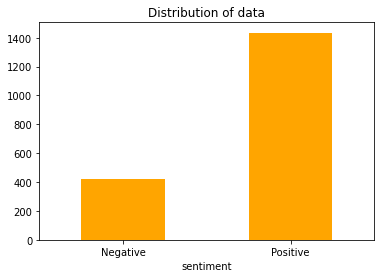

In [ ]:
# Plotting the distribution for dataset.
ax = Update_Despacito.groupby('sentiment').count().plot(kind='bar', color = 'orange', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, senti = list(Update_Despacito['comment']), list(Update_Despacito['sentiment'])

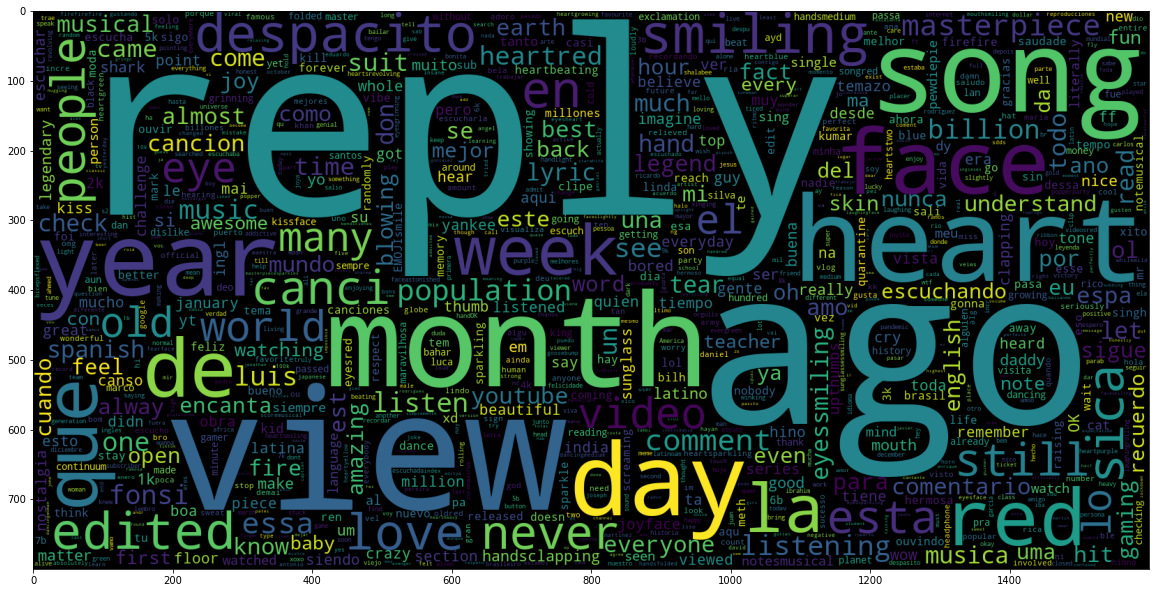

In [ ]:
data_neg = text[:421]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

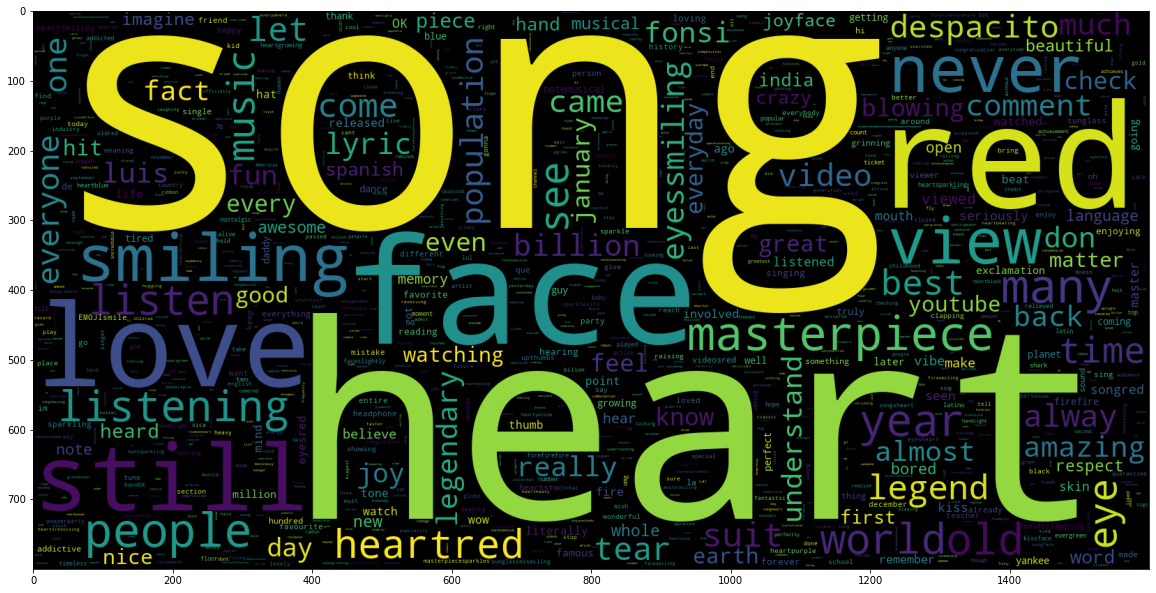

In [ ]:
data_pos = text[421:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text, senti,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  37967


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

    NEGATIVE       0.92      0.48      0.63        25
    POSITIVE       0.84      0.99      0.91        68

    accuracy                           0.85        93
   macro avg       0.88      0.73      0.77        93
weighted avg       0.86      0.85      0.83        93



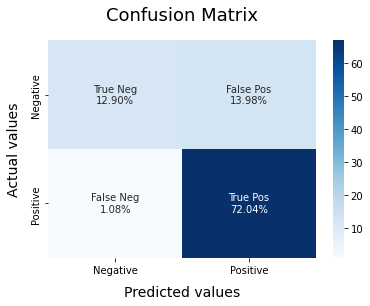

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    NEGATIVE       0.86      0.48      0.62        25
    POSITIVE       0.84      0.97      0.90        68

    accuracy                           0.84        93
   macro avg       0.85      0.73      0.76        93
weighted avg       0.84      0.84      0.82        93



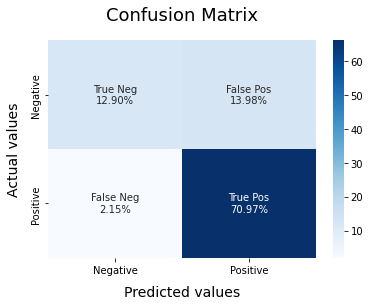

In [ ]:
SGDModel = SGDClassifier(loss="hinge", penalty="l2", max_iter=3000)
SGDModel.fit(X_train, y_train)
model_Evaluate(SGDModel)

#Using the Model

In [ ]:
file = open('/content/drive/MyDrive/For_Final/vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('/content/drive/MyDrive/For_Final/Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('/content/drive/MyDrive/For_Final/Sentiment-SGD.pickle','wb')
pickle.dump(SGDModel, file)
file.close()


SVCmodel has a higher accuracy.

In [ ]:
def load_models():
    
    # Load the vectoriser.
    file = open('/content/drive/MyDrive/For_Final/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the SVC Model.
    file = open('/content/drive/MyDrive/For_Final/Sentiment-SVC.pickle', 'rb')
    SVCmodel = pickle.load(file)
    file.close()
    
    return vectoriser, SVCmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    return df


###Shape of You

In [ ]:
Shape_of_You_dataset['Lang'] = Shape_of_You_dataset['comment'].apply(det)
Shape_of_You_dataset

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\nUp next\n4:33\nEd Sh...,en
1,The official music video for Ed Sheeran - Shap...,en
2,No me canso de escuchar esta rolita. <3,es
3,This song never gets old. No matter how much I...,en
4,Old but gold\nWho else just randomly remembere...,en
...,...,...
3971,"2020 CORONA: ""I'm in love with your body"".",en
3972,2022..!,Other
3973,Does anyone see it in 2022?,en
3974,Who will be the most viewed video in future?\n...,en


In [ ]:
top2 = Counter([item for item in Shape_of_You_dataset['Lang']])
language2 = pd.DataFrame(top2.most_common())
language2.columns = ['Lang','count']
language2.style.background_gradient(cmap='Greens')

,Lang,count
0,en,2797
1,Other,165
2,pt,155
3,es,138
4,de,50
5,tl,48
6,no,47
7,ro,42
8,nl,41
9,tr,41


In [ ]:
fig = px.bar(language, x="count", y="Lang", title='Comments of Languages',orientation='h', 
             width=1000, height=1000,color='Lang')
fig.show()

In [ ]:
Shape_of_You= Shape_of_You_dataset.loc[(Shape_of_You_dataset["Lang"] == "en") | (Shape_of_You_dataset["Lang"] == "Other")].dropna().reset_index().drop(columns = 'index')
Shape_of_You

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\nUp next\n4:33\nEd Sh...,en
1,The official music video for Ed Sheeran - Shap...,en
2,This song never gets old. No matter how much I...,en
3,Old but gold\nWho else just randomly remembere...,en
4,Road To 6B Views 🔥,en
...,...,...
2957,"2020 CORONA: ""I'm in love with your body"".",en
2958,2022..!,Other
2959,Does anyone see it in 2022?,en
2960,Who will be the most viewed video in future?\n...,en


In [ ]:
vectoriser, SVCmodel = load_models()
 # Text to classify should be in a list.
text_2 = Shape_of_You["comment"].tolist()
Update_Shape_of_You = predict(vectoriser, SVCmodel, text_2)
Update_Shape_of_You.head()

,text,sentiment
0,SKIP NAVIGATION\nSIGN IN\nUp next\n4:33\nEd Sh...,NEGATIVE
1,The official music video for Ed Sheeran - Shap...,POSITIVE
2,This song never gets old. No matter how much I...,POSITIVE
3,Old but gold\nWho else just randomly remembere...,NEGATIVE
4,Road To 6B Views 🔥,NEGATIVE


In [ ]:
Update_Shape_of_You_count = Update_Shape_of_You.groupby('sentiment').count().rename(columns = {"text": "Shape_of_You"}).T
Update_Shape_of_You_count

sentiment,NEGATIVE,POSITIVE
Shape_of_You,277,2685


###See You Again

In [ ]:
See_You_Again_dataset['Lang'] = See_You_Again_dataset['comment'].apply(det)
See_You_Again_dataset

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\nUp next\n5:55\nEd Sh...,en
1,Download the new Furious 7 Soundtrack Deluxe V...,en
2,Don't cry because there gone\nSmile because th...,en
3,Paul Walker por siempre vivirá en nuestros cor...,es
4,"Its January 2022, lets see how many legends ar...",en
...,...,...
3935,"Dezembro de 2021 , mais uma vez eu aqui 😔 nós ...",pt
3936,I listing to this song when I miss my grandpa ...,en
3937,0% Bad words\n0% Alcohol\n0% Drugs\n100% Emoti...,en
3938,Rest In Paradise Paul Walker 🙏\n I’ll nev...,no


In [ ]:
top3 = Counter([item for item in See_You_Again_dataset['Lang']])
language3 = pd.DataFrame(top3.most_common())
language3.columns = ['Lang','count']
language3.style.background_gradient(cmap='Greens')

,Lang,count
0,en,2934
1,pt,318
2,es,288
3,af,82
4,de,45
5,ro,33
6,da,26
7,no,25
8,ca,24
9,ru,24


In [ ]:
fig = px.bar(language3, x="count", y="Lang", title='Comments of Languages',orientation='h', 
             width=1000, height=1000,color='Lang')
fig.show()

In [ ]:
See_You_Again= See_You_Again_dataset.loc[(See_You_Again_dataset["Lang"] == "en") | (See_You_Again_dataset["Lang"] == "Other")].dropna().reset_index().drop(columns = 'index')
See_You_Again

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\nUp next\n5:55\nEd Sh...,en
1,Download the new Furious 7 Soundtrack Deluxe V...,en
2,Don't cry because there gone\nSmile because th...,en
3,"Its January 2022, lets see how many legends ar...",en
4,Thinking back this song hits me hard,en
...,...,...
2936,I don't care about the Dislikes \nI don't care...,en
2937,This song is just a masterpiece #rippaulwalker,en
2938,Paul Walker is not dead.He is still alive in o...,en
2939,I listing to this song when I miss my grandpa ...,en


In [ ]:
 # Text to classify should be in a list.
text_3 = See_You_Again["comment"].tolist()
Update_See_You_Again = predict(vectoriser, SVCmodel, text_3)
Update_See_You_Again.head()

,text,sentiment
0,SKIP NAVIGATION\nSIGN IN\nUp next\n5:55\nEd Sh...,NEGATIVE
1,Download the new Furious 7 Soundtrack Deluxe V...,POSITIVE
2,Don't cry because there gone\nSmile because th...,NEGATIVE
3,"Its January 2022, lets see how many legends ar...",POSITIVE
4,Thinking back this song hits me hard,POSITIVE


In [ ]:
Update_See_You_Again_count = Update_See_You_Again.groupby('sentiment').count().rename(columns = {"text": "See_You_Again"}).T
Update_See_You_Again_count

sentiment,NEGATIVE,POSITIVE
See_You_Again,474,2467


###Uptown Funk

In [ ]:
Uptown_Funk_dataset['Lang'] = Uptown_Funk_dataset['comment'].apply(det)
Uptown_Funk_dataset

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\nUp next\n3:47\nBruno...,en
1,NaN,Other
2,NaN,Other
3,Official Video for Uptown Funk by Mark Ronson ...,en
4,Bruno Mars gives me Michael Jackson vibes 🙂🙂 \...,en
...,...,...
3956,"If you're listening this in 2021, ur a Legend",en
3957,"Mark: listen bruno, i wanna retire from this i...",en
3958,I am obsessed with this song. It's one of the ...,en
3959,🖒😎,Other


In [ ]:
top4 = Counter([item for item in Uptown_Funk_dataset['Lang']])
language4 = pd.DataFrame(top4.most_common())
language4.columns = ['Lang','count']
language4.style.background_gradient(cmap='Greens')

,Lang,count
0,en,2808
1,es,339
2,pt,205
3,Other,81
4,de,44
5,ro,37
6,et,30
7,it,29
8,so,29
9,af,28


In [ ]:
fig = px.bar(language4, x="count", y="Lang", title='Comments of Languages',orientation='h', 
             width=1000, height=1000,color='Lang')
fig.show()

In [ ]:
Uptown_Funk= Uptown_Funk_dataset.loc[(Uptown_Funk_dataset["Lang"] == "en") | (Uptown_Funk_dataset["Lang"] == "Other")].dropna().reset_index().drop(columns = 'index')
Uptown_Funk

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\nUp next\n3:47\nBruno...,en
1,Official Video for Uptown Funk by Mark Ronson ...,en
2,Bruno Mars gives me Michael Jackson vibes 🙂🙂 \...,en
3,"The song is obviously amazing, but gotta say t...",en
4,This song never gets old. No matter how much I...,en
...,...,...
2881,"Japanese. I knew this song three years ago, an...",en
2882,"If you're listening this in 2021, ur a Legend",en
2883,"Mark: listen bruno, i wanna retire from this i...",en
2884,I am obsessed with this song. It's one of the ...,en


In [ ]:
 # Text to classify should be in a list.
text_4 = Uptown_Funk["comment"].tolist()
Update_Uptown_Funk = predict(vectoriser, SVCmodel, text_4)
Update_Uptown_Funk

,text,sentiment
0,SKIP NAVIGATION\nSIGN IN\nUp next\n3:47\nBruno...,NEGATIVE
1,Official Video for Uptown Funk by Mark Ronson ...,POSITIVE
2,Bruno Mars gives me Michael Jackson vibes 🙂🙂 \...,POSITIVE
3,"The song is obviously amazing, but gotta say t...",POSITIVE
4,This song never gets old. No matter how much I...,POSITIVE
...,...,...
2881,"Japanese. I knew this song three years ago, an...",POSITIVE
2882,"If you're listening this in 2021, ur a Legend",POSITIVE
2883,"Mark: listen bruno, i wanna retire from this i...",POSITIVE
2884,I am obsessed with this song. It's one of the ...,POSITIVE


In [ ]:
Update_Uptown_Funk_count = Update_Uptown_Funk.groupby('sentiment').count().rename(columns = {"text": "Uptown_Funk"}).T
Update_Uptown_Funk_count

sentiment,NEGATIVE,POSITIVE
Uptown_Funk,314,2572


###Gangnam Style

In [ ]:
Gangnam_Style_dataset['Lang'] = Gangnam_Style_dataset['comment'].apply(det)
Gangnam_Style_dataset

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\n3:31\nShakira - Waka...,en
1,NaN,Other
2,PSY - ‘I LUV IT’ M/V @ https://youtu.be/Xvjnoa...,en
3,For those who dont know: This song literally b...,en
4,we didn't realise how good we had it back in t...,en
...,...,...
3974,I don't care if it's 8 years later this song n...,en
3975,i see we haven't forgotten the backup plan. go...,en
3976,10 years almost already..,en
3977,2012: I don't like this song\n\n2020: this is ...,en


In [ ]:
top5 = Counter([item for item in Gangnam_Style_dataset['Lang']])
language5 = pd.DataFrame(top5.most_common())
language5.columns = ['Lang','count']
language5.style.background_gradient(cmap='Greens')

,Lang,count
0,en,2838
1,es,434
2,pt,359
3,ru,57
4,ko,31
5,de,26
6,ca,21
7,it,19
8,da,15
9,fr,15


In [ ]:
fig = px.bar(language5, x="count", y="Lang", title='Comments of Languages',orientation='h', 
             width=1000, height=1000,color='Lang')
fig.show()

In [ ]:
Gangnam_Style = Gangnam_Style_dataset.loc[(Gangnam_Style_dataset["Lang"] == "en") | (Gangnam_Style_dataset["Lang"] == "Other")].dropna().reset_index().drop(columns = 'index')
Gangnam_Style

,comment,Lang
0,SKIP NAVIGATION\nSIGN IN\n3:31\nShakira - Waka...,en
1,PSY - ‘I LUV IT’ M/V @ https://youtu.be/Xvjnoa...,en
2,For those who dont know: This song literally b...,en
3,we didn't realise how good we had it back in t...,en
4,"Its January 2022, lets see how many legends ar...",en
...,...,...
2846,I don't care if it's 8 years later this song n...,en
2847,i see we haven't forgotten the backup plan. go...,en
2848,10 years almost already..,en
2849,2012: I don't like this song\n\n2020: this is ...,en


In [ ]:
 # Text to classify should be in a list.
text_5 = Gangnam_Style["comment"].tolist()
Update_Gangnam_Style = predict(vectoriser, SVCmodel, text_5)
Update_Gangnam_Style.head()

,text,sentiment
0,SKIP NAVIGATION\nSIGN IN\n3:31\nShakira - Waka...,NEGATIVE
1,PSY - ‘I LUV IT’ M/V @ https://youtu.be/Xvjnoa...,POSITIVE
2,For those who dont know: This song literally b...,POSITIVE
3,we didn't realise how good we had it back in t...,NEGATIVE
4,"Its January 2022, lets see how many legends ar...",POSITIVE


In [ ]:
Update_Gangnam_Style_count = Update_Gangnam_Style.groupby('sentiment').count().rename(columns = {"text": "Gangnam_Style"}).T
Update_Gangnam_Style_count

sentiment,NEGATIVE,POSITIVE
Gangnam_Style,442,2409


In [ ]:
whole_data = pd.concat([Update_Despacito_count, Update_Shape_of_You_count, Update_See_You_Again_count, Update_Uptown_Funk_count, Update_Gangnam_Style_count],axis=0)
whole_data.style.background_gradient(cmap='Accent')

sentiment,NEGATIVE,POSITIVE
Despacito,421,1435
Shape_of_You,277,2685
See_You_Again,474,2467
Uptown_Funk,314,2572
Gangnam_Style,442,2409
